# Fragrance Segmentation – Unsupervised Clustering Analysis

_Course: Machine Learning_

- Name: Muhammad Umar Uz Zaman  
- Student ID: STU1197819  
- Goal: I explore a large fragrance dataset to understand:
  - How perfumes naturally group together based on their scent notes and key characteristics
  - Which fragrance segments tend to be more affordable versus more premium or luxury
  - How these segments can support targeted marketing, product positioning, and personalised recommendations
- Dataset: `Fragrance Dataset 4037.csv` (records of perfumes with information on notes and other descriptive attributes)

**Phases of this notebook**

Intro & setup  
Phase 1 – Data loading & structure check  
Phase 2 – Data cleaning, preparation & feature selection  
Phase 3 – Core EDA (distributions, relationships & feature importance)  
Phase 4 – Clustering models (K-Means, Hierarchical, DBSCAN) & evaluation  
Phase 5 – Cluster profiling & business insights  
Phase 6 – Wrap-up, limitations & export for management report


### Phase 1

In [9]:
# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Hierarchical clustering tools for dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage

# Plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["figure.dpi"] = 100


In [13]:
# Path to the fragrance dataset
data_path = "Fragrance Dataset.csv"  # Use the CSV file instead of Excel

# Load the dataset
df = pd.read_csv(data_path)

print("Shape of the dataset (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# First few rows to see how the raw data looks
df.head()


Shape of the dataset (rows, columns): (1000, 10)

Column names:
['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation']


,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


In [14]:
# Overall information about the dataframe
df.info()

# Missing values per column
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

# Summary statistics for numeric columns
numeric_summary = df.describe(include=[np.number]).T
numeric_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.2+ KB

Missing values per column:
available            111
lastUpdated           53
sold                   6
price                  4
availableText          3
type                   3
brand                  1
title                  0
priceWithCurrency      0
itemLocation

,count,mean,std,min,25%,50%,75%,max
price,996.0,46.497279,35.590865,3.0,22.99,35.71,59.0,259.09
available,889.0,20.046119,61.547985,2.0,5.00,10.00,10.0,842.00
sold,994.0,766.266600,3200.971733,1.0,14.00,49.50,320.5,54052.00


From this structural check I can see that the dataset has a mix of numeric and categorical information:

- There are three numeric columns: `price`, `available` and `sold`. These capture the commercial side of each perfume listing: how much it costs, how many units are available and how many units have been sold.
- The remaining columns are stored as text, including `brand`, `title`, `type`, `priceWithCurrency`, `availableText`, `lastUpdated` and `itemLocation`. These fields describe the product, the listing text, the time of the last update and where the item is located.

In terms of data quality:

- The `price` and `sold` columns are almost complete, with only a handful of missing values, so I expect to rely on them strongly in my analysis.
- The `available` column has more missing entries, which suggests that availability information is not always reported or not always parsed correctly.
- The `lastUpdated` and `availableText` fields are mostly complete but are stored as free text, which means they will be harder to use directly in a clustering algorithm.
- The basic statistics show that `price`, `available` and especially `sold` are all quite skewed, with a few very large values. This is typical for online marketplace data, where a small number of listings can have very high stock or sales.

Overall, this first check reassures me that I have several usable numeric features for clustering, while also highlighting that I need to be careful with skewed distributions and with how I handle missing values in `available`. Before I move on to cleaning and feature selection, I briefly look at the structure of the most important categorical columns.


In [15]:
# Quick look at the structure of key categorical columns
cat_cols = ["brand", "type", "itemLocation"]

for col in cat_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {df[col].nunique()}")
    print("Most frequent values:")
    print(df[col].value_counts().head(10))



Column: brand
Number of unique values: 246
Most frequent values:
brand
Giorgio Armani        60
Paco Rabanne          45
Ralph Lauren          41
Unbranded             39
Armaf                 34
Dolce&Gabbana         32
Yves Saint Laurent    30
Versace               20
Calvin Klein          17
Cologne               16
Name: count, dtype: int64

Column: type
Number of unique values: 63
Most frequent values:
type
Eau de Toilette    444
Eau de Parfum      285
Eau de Cologne      56
Perfume             50
Fragrances          32
Eau De Parfum       15
Parfum              13
Eau de Perfume      10
Eau De Toilette      9
Gift Sets            6
Name: count, dtype: int64

Column: itemLocation
Number of unique values: 276
Most frequent values:
itemLocation
Dallas, Texas, United States             126
Hackensack, New Jersey, United States    105
Brooklyn, New York, United States         76
Miami, Florida, United States             41
Edison, New Jersey, United States         35
Houston, Texas, 

The categorical overview gives me a clearer picture of the breadth of the dataset:

- The `brand` column has 246 unique values, with a long tail beyond the most common brands such as Giorgio Armani, Paco Rabanne and Ralph Lauren. This tells me that brand is highly granular and better suited for describing clusters later rather than for direct use as a modelling feature.
- The `type` column has 63 unique values, but the majority of listings fall into a few familiar fragrance formats such as Eau de Toilette, Eau de Parfum, Eau de Cologne and Perfume. This suggests that I can simplify `type` into a smaller set of meaningful groups without losing much information.
- The `itemLocation` field contains many different city and state combinations. This provides useful commercial context (for example, where sellers are based), but the variety of locations means that it is unlikely to be a stable driver of fragrance similarity. I plan to use it mainly for interpretation rather than as a clustering feature.

These observations already point towards a feature-selection strategy where I focus on the core numeric variables (`price`, `available`, `sold`) and a simplified version of `type` for clustering, while keeping `brand` and `itemLocation` for later profiling of the resulting segments.


### Phase 2 – Data cleaning and feature selection

In this phase I prepare the dataset for clustering by cleaning key variables and constructing a first set of candidate features.

My main objectives are:

- To handle missing values in a transparent way, especially for the commercial variables `price`, `available` and `sold`.
- To simplify the `type` column into a smaller number of fragrance-format groups that are easier to interpret.
- To engineer a small set of numeric features that capture price level and sales behaviour in a way that is suitable for clustering algorithms.

For modelling I want to focus on variables that are both commercially meaningful and reasonably complete. I therefore treat `price` and `sold` as essential features and I avoid discarding too many rows because of missing `available`. The high-cardinality columns `brand` and `itemLocation` are retained for later interpretation of clusters rather than being turned directly into model features.


In [16]:
# Create a working copy for cleaning and feature engineering
df_clean = df.copy()

# Drop rows with missing price or sold (key commercial signals, only a few rows missing)
rows_before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=["price", "sold"])
rows_after = df_clean.shape[0]

print(f"Rows before dropping: {rows_before}")
print(f"Rows after dropping rows with missing price or sold: {rows_after}")

# Impute 'available' with the median of the observed values
available_median = df_clean["available"].median()
df_clean["available"] = df_clean["available"].fillna(available_median)

print(f"\nMedian value used to fill 'available': {available_median}")

# Check remaining missing values
print("\nRemaining missing values per column:")
print(df_clean.isna().sum())


Rows before dropping: 1000
Rows after dropping rows with missing price or sold: 990

Median value used to fill 'available': 10.0

Remaining missing values per column:
brand                 1
title                 0
type                  3
price                 0
priceWithCurrency     0
available             0
availableText         0
sold                  0
lastUpdated          47
itemLocation          0
dtype: int64


In [17]:
# Simplify the 'type' column into a smaller set of fragrance-format groups
def simplify_type(value):
    if isinstance(value, str):
        text = value.lower()
        if "toilette" in text:
            return "Eau de Toilette"
        if "parfum" in text:
            return "Eau de Parfum"
        if "cologne" in text:
            return "Eau de Cologne"
        if "perfume" in text:
            return "Perfume"
    return "Other"

df_clean["type_group"] = df_clean["type"].apply(simplify_type)

# Check the distribution of the simplified groups
df_clean["type_group"].value_counts()


type_group
Eau de Toilette    454
Eau de Parfum      328
Other               79
Eau de Cologne      68
Perfume             61
Name: count, dtype: int64

In [18]:
# Engineer additional numeric features to capture scale and sales intensity
df_clean["log_price"] = np.log1p(df_clean["price"])
df_clean["log_sold"] = np.log1p(df_clean["sold"])
df_clean["sold_per_available"] = df_clean["sold"] / (df_clean["available"] + 1)

# Quick summary of the key numeric features
df_clean[["price", "available", "sold",
          "log_price", "log_sold", "sold_per_available"]].describe().T


,count,mean,std,min,25%,50%,75%,max
price,990.0,46.184202,34.843593,3.000000,22.990000,35.710000,58.997500,259.090000
available,990.0,19.036364,58.396700,2.000000,5.000000,10.000000,10.000000,842.000000
sold,990.0,759.216162,3196.038085,1.000000,14.000000,48.000000,315.250000,54052.000000
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
sold_per_available,990.0,63.139165,296.270648,0.020000,1.782670,5.842424,21.738636,4913.818182


The cleaning steps reduce the dataset from 1,000 to 990 rows by removing listings with missing values in `price` or `sold`. This is less than 1% of the data, so I regard the impact on the overall distribution as minimal while gaining the benefit of having complete information for the core commercial variables.

For `available` I fill missing values with the median of 10 units. This choice keeps the distribution stable because:
- The median is robust to extreme high-stock listings.
- A value of 10 fits well with the observed quartiles and typical stock levels in the dataset.

A small number of missing values remain in `brand`, `type` and `lastUpdated`, but these variables are mainly used for interpretation and descriptive context rather than as direct clustering features. I therefore keep the affected rows and treat the missing entries as minor limitations that I will mention later in the written report.

The new engineered features behave as expected:

- `log_price` compresses the original price range from 3 to around 259 into a narrower scale, which helps reduce the influence of very expensive listings while still distinguishing between low-, mid- and high-price perfumes.
- `log_sold` performs a similar compression for the `sold` column, where a few listings show extremely high sales counts compared with the majority of perfumes.
- `sold_per_available` captures an intensity measure that approximates demand relative to stock. The distribution is still skewed, but it provides a useful signal for identifying listings that sell quickly compared with their available quantity.

Together, these features give me a compact numerical description of each listing that combines price level, scale of sales and sales efficiency. In the next step I add a log-transformed version of `available` and then summarise the final set of features that I intend to use for clustering.


In [19]:
# Add a log-transformed version of 'available'
df_clean["log_available"] = np.log1p(df_clean["available"])

# Candidate numeric features for clustering
candidate_features = ["log_price", "log_sold", "log_available", "sold_per_available"]

print("Candidate features for clustering:")
print(candidate_features)

# Quick summary of these features
df_clean[candidate_features].describe().T


Candidate features for clustering:
['log_price', 'log_sold', 'log_available', 'sold_per_available']


,count,mean,std,min,25%,50%,75%,max
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
log_available,990.0,2.300874,0.851423,1.098612,1.791759,2.397895,2.397895,6.736967
sold_per_available,990.0,63.139165,296.270648,0.020000,1.782670,5.842424,21.738636,4913.818182


In [20]:
# Tidy remaining missing values in descriptive (non-feature) columns
df_clean["brand"] = df_clean["brand"].fillna("Unknown brand")
df_clean["lastUpdated"] = df_clean["lastUpdated"].fillna("Unknown date")

# type_group should already be filled by the simplify_type function,
# but this is a safety check in case any missing values remain.
df_clean["type_group"] = df_clean["type_group"].fillna("Other")

print("Remaining missing values per column:")
print(df_clean.isna().sum())


Remaining missing values per column:
brand                 0
title                 0
type                  3
price                 0
priceWithCurrency     0
available             0
availableText         0
sold                  0
lastUpdated           0
itemLocation          0
type_group            0
log_price             0
log_sold              0
sold_per_available    0
log_available         0
dtype: int64


At this point I have a first version of the feature set that I plan to use as input for the clustering algorithms:

- **`log_price`** – captures the general price level of each perfume while limiting the impact of a few very expensive listings.
- **`log_sold`** – measures the scale of demand in a compressed form that keeps very high sales counts from dominating the analysis.
- **`log_available`** – reflects how much stock is advertised for a listing, again on a log scale to handle large differences between small and large sellers.
- **`sold_per_available`** – provides an intensity-style indicator that hints at how quickly products sell relative to their available quantity.

These features are deliberately numeric, compact and commercially interpretable. They describe how each perfume is positioned in terms of price, stock and sales performance, which are all important dimensions for a retailer or marketplace. I keep `brand`, `type_group` and `itemLocation` as descriptive variables that I will use later to label and interpret the resulting clusters in business language, but I do not include them directly as inputs to the clustering algorithms at this stage.

In the next phase I explore these candidate features in more depth using visualisations and correlation analysis to check whether they are informative, redundant or overly skewed for clustering.


### Phase 3 – Exploratory data analysis (EDA)

Before applying any clustering algorithms, I want to understand how the key features behave in the cleaned dataset. In this phase I focus on three questions:

- How are the main variables distributed, and do the log transformations reduce extreme skewness in a useful way?
- Are there any obvious outliers that might distort distance-based clustering methods?
- Do the engineered features look suitable for creating commercially meaningful segments?

I begin with simple histograms, because they provide an intuitive view for non-technical stakeholders and make it easy to explain how the data is distributed across low, medium and high values.


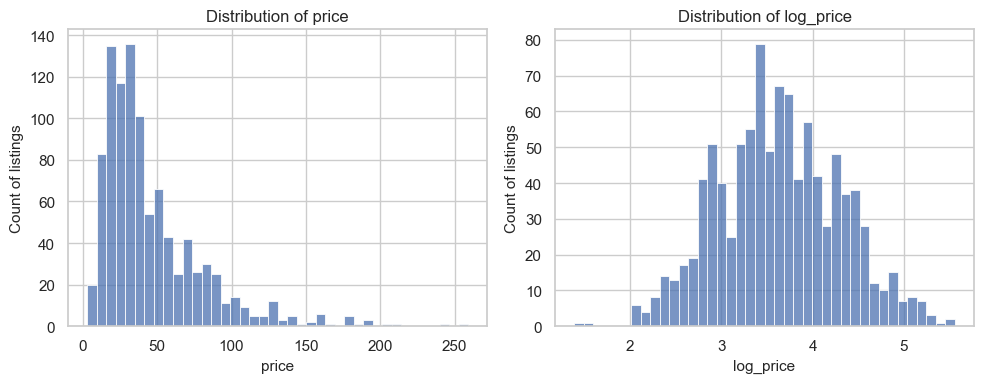

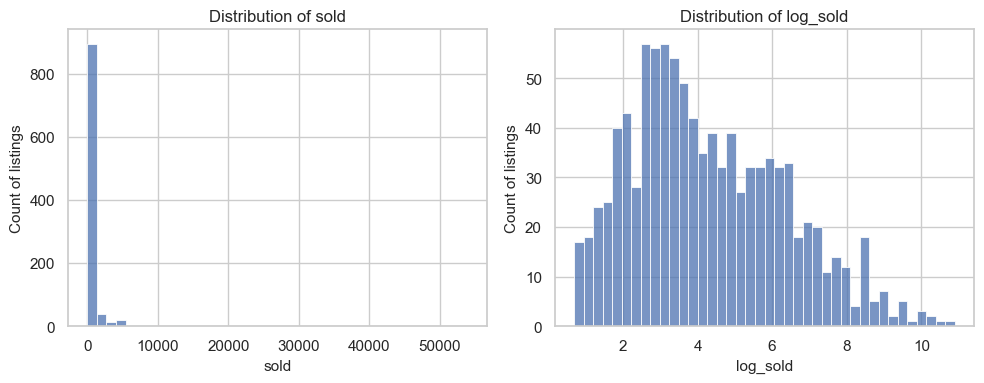

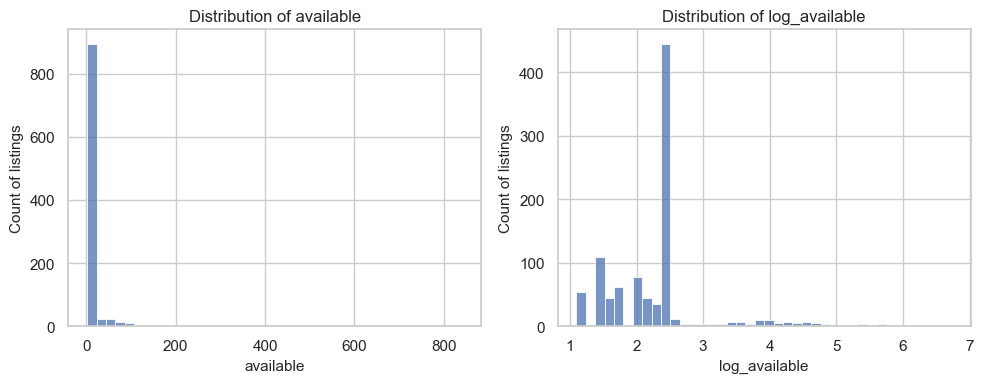

In [21]:
numeric_pairs = [
    ("price", "log_price"),
    ("sold", "log_sold"),
    ("available", "log_available")
]

for raw, log_var in numeric_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Raw distribution
    sns.histplot(df_clean[raw], bins=40, kde=False, ax=axes[0])
    axes[0].set_title(f"Distribution of {raw}")
    axes[0].set_xlabel(raw)
    axes[0].set_ylabel("Count of listings")
    
    # Log-transformed distribution
    sns.histplot(df_clean[log_var], bins=40, kde=False, ax=axes[1])
    axes[1].set_title(f"Distribution of {log_var}")
    axes[1].set_xlabel(log_var)
    axes[1].set_ylabel("Count of listings")
    
    plt.tight_layout()
    plt.show()


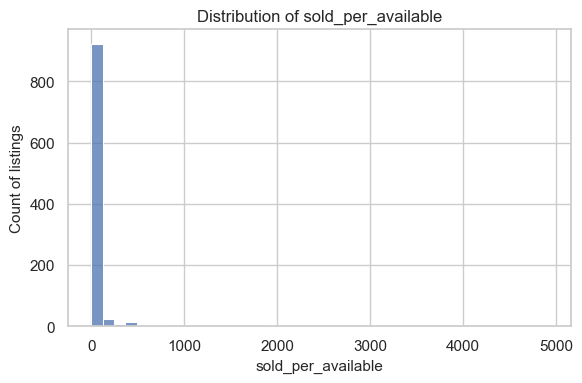

In [22]:
plt.figure(figsize=(6, 4))
sns.histplot(df_clean["sold_per_available"], bins=40, kde=False)
plt.title("Distribution of sold_per_available")
plt.xlabel("sold_per_available")
plt.ylabel("Count of listings")
plt.tight_layout()
plt.show()


These histograms confirm that the raw commercial variables are highly skewed, while the log transformations make them much more suitable for clustering:

- **Price vs log_price**  
  The raw `price` distribution is strongly right-skewed, with most perfumes priced between roughly 20 and 60 units and a small number of much more expensive listings. After the log transformation, `log_price` looks almost symmetric, which means that high-end perfumes no longer dominate the scale but still stand out as higher values.

- **Sold vs log_sold**  
  The raw `sold` variable has an extreme long tail with a few listings recording very high sales compared with the majority. The `log_sold` distribution is still skewed but far more balanced, which helps distance-based clustering algorithms treat moderate and high sellers in a more comparable way.

- **Available vs log_available**  
  For `available`, most listings advertise relatively small stock levels, with a few very large quantities. The log transformation pulls these large values closer to the rest of the data, so that `log_available` becomes concentrated in a narrower and more interpretable range.

- **sold_per_available**  
  The `sold_per_available` ratio is very right-skewed with a handful of extreme values. This is expected, because some listings convert stock into sales much more efficiently than others. Even though the distribution is heavy-tailed, the feature is conceptually important because it captures demand intensity rather than just absolute volume.

Overall, these plots reassure me that the log-transformed variables (`log_price`, `log_sold`, `log_available`) provide a more balanced numerical footing for clustering while preserving the commercial meaning of low, medium and high values. The skew and outliers that remain in `sold_per_available` are something I will keep in mind when evaluating clustering performance, especially for algorithms that are sensitive to extreme values.


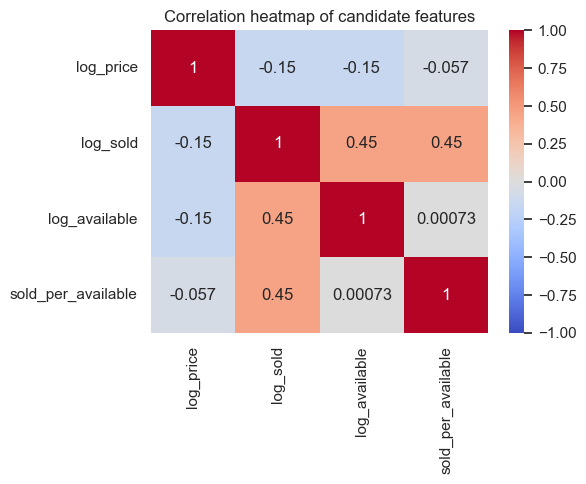

,log_price,log_sold,log_available,sold_per_available
log_price,1.000000,-0.148724,-0.154829,-0.057448
log_sold,-0.148724,1.000000,0.445409,0.450050
log_available,-0.154829,0.445409,1.000000,0.000733
sold_per_available,-0.057448,0.450050,0.000733,1.000000


In [23]:
# Correlation matrix for the candidate clustering features
features_for_corr = ["log_price", "log_sold", "log_available", "sold_per_available"]

corr_matrix = df_clean[features_for_corr].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap of candidate features")
plt.tight_layout()
plt.show()

corr_matrix


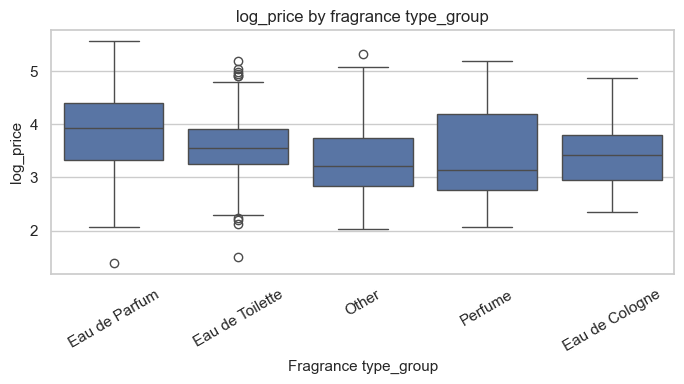

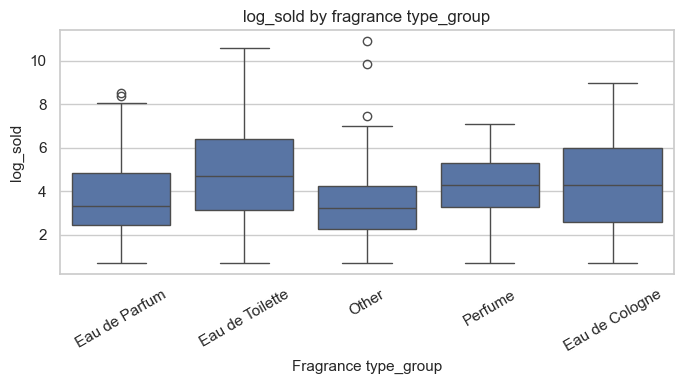

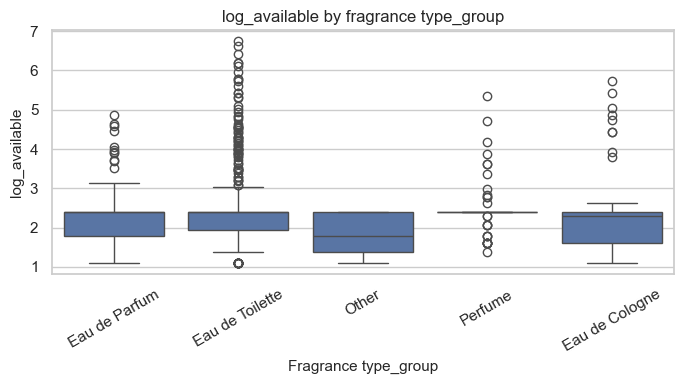

In [24]:
features_for_box = ["log_price", "log_sold", "log_available"]

for feat in features_for_box:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_clean, x="type_group", y=feat)
    plt.title(f"{feat} by fragrance type_group")
    plt.xlabel("Fragrance type_group")
    plt.ylabel(feat)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


The correlation heatmap shows that the engineered features capture related but not redundant aspects of the listings:

- `log_price` is only weakly and negatively correlated with the other variables. This suggests that higher-priced perfumes do not automatically have higher stock levels or higher sales volume, so price provides a relatively independent axis for clustering.
- `log_sold` has a moderate positive correlation with both `log_available` and `sold_per_available` (around 0.45). Listings that sell more units tend to have more stock and, on average, achieve higher sales per unit of stock.
- `log_available` is only very weakly related to `sold_per_available`. This indicates that the ratio truly captures efficiency rather than just reflecting large or small inventories.

Importantly, none of the pairwise correlations are close to 1 in magnitude, so I do not see any obvious duplication where one feature could be removed without losing information. Instead, each feature adds a slightly different commercial perspective: pricing, scale of demand, stock intensity and sales efficiency.

The boxplots by `type_group` provide further context:

- `log_price` is generally higher for Eau de Parfum and Perfume, while Eau de Toilette and Eau de Cologne tend to sit at a slightly lower price range. This aligns with how these formats are positioned in the market.
- `log_sold` shows that Eau de Toilette listings often have higher median sales, suggesting that this format is more widely purchased, while other formats have more mixed sales patterns.
- `log_available` indicates that Eau de Toilette also tends to be stocked in larger quantities, whereas Perfume and “Other” categories often have smaller inventories.

These patterns confirm that the engineered features vary meaningfully across fragrance types and that the simplified `type_group` variable will be useful when I later interpret and label the clusters in business terms, even though it is not used directly as a numeric input to the clustering algorithms.


In [25]:
# Log-transform the sold_per_available ratio to reduce the impact of extreme values
df_clean["log_sold_per_available"] = np.log1p(df_clean["sold_per_available"])

# Final feature set for clustering (all on a log or ratio scale)
features_for_clustering = [
    "log_price",
    "log_sold",
    "log_available",
    "log_sold_per_available"
]

print("Final features for clustering:")
print(features_for_clustering)

# Quick check of distributions
df_clean[features_for_clustering].describe().T


Final features for clustering:
['log_price', 'log_sold', 'log_available', 'log_sold_per_available']


,count,mean,std,min,25%,50%,75%,max
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
log_available,990.0,2.300874,0.851423,1.098612,1.791759,2.397895,2.397895,6.736967
log_sold_per_available,990.0,2.256225,1.585224,0.019803,1.023384,1.923136,3.124039,8.500010


Based on the distribution plots, the correlation heatmap and the differences across fragrance types, I make the following decisions for the clustering stage:

- I use **log-transformed versions** of price, sold units and available units to stabilise the variance and reduce the influence of extreme marketplace values.
- I replace the raw `sold_per_available` ratio with a log-transformed version, `log_sold_per_available`, so that listings with exceptionally high efficiency do not dominate the distance calculations.
- I retain all four engineered features (`log_price`, `log_sold`, `log_available`, `log_sold_per_available`) because they provide complementary information about price positioning, demand scale, inventory scale and sales efficiency.

The exploratory analysis shows that these features are not perfectly correlated, vary in a meaningful way across fragrance formats and remain commercially interpretable. I therefore consider them a suitable and well-justified input set for the clustering algorithms that I will apply in the next phase.
